# House Price Predictions

# Loading Data
The DataFrame contains information about property prices. Each sample represents an ad on the Properati website. The DataFrame includes details such as the creation date of the ad, the property locations (coordinates and suburb), square footage, number of rooms, the property type, and, most importantly, the prices of these properties. 

Let's to import the data from the csv

In [536]:
import os
# Current directory 
current_dir = os.getcwdb().decode()
# Path to data
data_path = os.path.join(current_dir,'../Data/')
# Files in folder
files = os.listdir(data_path)
# Csv file
data_file = [elem for elem in files if elem.startswith('data')]
# CSV path
path = data_path + data_file[0]

## Raw Data Filtering and Initial Preparation 

The Raw CSV file downloaded from the properati's web contains 1.000.000 samples, but many of them are not relevant in the construction of the model being developed and they souldn't be included.

The next code prepares a filtered and cleaned dataset that is suitable for building the desired model. This process significantly reduces the dataset's size and focuses only on the relevant samples, which is crucial for efficient and accurate model development.


In [537]:
import pandas as pd
import sqlite3

def data_import(path: str) -> pd.DataFrame:
    """ Generates A DataFrame By Filtering The Raw Data"""
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(path)
    # Connect to an SQLite database in memory (':memory:')
    conn = sqlite3.connect(':memory:')
    # Store the 'data' DataFrame in the SQLite database
    df.to_sql('raw_data', 
              conn, 
              index = False)
    # Column names to select
    columns = ", ".join(['lat', 'lon', 'l2', 'l3', 'rooms',
                         'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
                         'description', 'property_type', 'price'])
    # SQL condition to filter data
    condition = "(l1 == 'Argentina') AND (operation_type == 'Venta') AND (currency == 'USD') AND (price > 10000) AND (price < 1500000) AND (surface_total > 0 OR surface_total IS NULL)"
    # Create an SQL query
    query = f"SELECT {columns} FROM raw_data WHERE {condition}"
    # Execute the SQL query on the database
    df = pd.read_sql_query(query, conn)
    # Rename columns
    df.columns = ['latitude', 'longitude', 'suburb_l2', 'suburb_l3', 'rooms',
                  'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
                  'description', 'property_type', 'price']
    # Remove duplicate rows 
    df.drop_duplicates(inplace = True)
    
    return df

data = data_import(path)

In [538]:
shape = data.shape

print(f"The data contains {shape[1]} columns and {shape[0]} samples")

The data contains 12 columns and 547461 samples


# Features
Before diving into the details of the dataset, let's provide a brief overview of the key features we'll be exploring:
<br>
- **latitude, longitude:** These features represent the geographical coordinates (latitude and longitude) with the property's exact location.

- **rooms, bedrooms and bathrooms:** The number of rooms within each property.

- **surface_total, surface_covered:** These features describe the property's total surface area in square meters (m²). "surface_total" encompasses the entire property's area, while "surface_covered" focuses on the enclosed portion.

- **price:** The price, expressed USD

- **suburb_l2, suburb_l3:** "suburb_l2" reveals second-level suburb information, indicating a region. "suburb_l3" offers more specific details, indicating the suburb.

- **property_type:** This feature classifies the type of property, whether it is a house, apartment, lot, or another property type.

- **description**: This feature contains descriptive and relevant information about the properti properties
<br>
Now, let's proceed to go deeper into each of these features, their data types, and their significance in our analysis. 

In [539]:
# Data types 
data.dtypes.sort_values()

latitude           float64
longitude          float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
suburb_l2           object
suburb_l3           object
description         object
property_type       object
dtype: object

## Object Columns
<br>

### Suburb_l2

"The 'suburb_l2' column provides information about the general region where each property is situated. To gain a deeper understanding of the data, we will begin by conducting an analysis of the various regions represented in this column. This analysis will allow us to identify and categorize the different regions, providing valuable insights into the geographical distribution of the properties.

Our specific focus will be on properties located within Buenos Aires area.


In [540]:
# Unique values for suburb_l2 column
suburb_l2_unique = data['suburb_l2'].unique()

print(f"There are {len(suburb_l2_unique)} unique values in suburb_l2 column.\n\nThe first 10 unique values are the following:")

# Print the first 10 unique values of "suburb_l2" column 
for (i, suburb) in enumerate(suburb_l2_unique):
    if i < 10:
        print(f"{i + 1}) {suburb}")

There are 28 unique values in suburb_l2 column.

The first 10 unique values are the following:
1) Bs.As. G.B.A. Zona Norte
2) Bs.As. G.B.A. Zona Oeste
3) Corrientes
4) Santa Fe
5) Buenos Aires Interior
6) Buenos Aires Costa Atlántica
7) Mendoza
8) Bs.As. G.B.A. Zona Sur
9) Capital Federal
10) Córdoba


Since the model is specifically designed for properties in the Buenos Aires area, we will focus on considering districts located within that region.

Therefore, the districts considered are:
- 'Capital Federal'
- 'Bs.As. G.B.A. Zona Norte'
- 'Bs.As. G.B.A. Zona Oeste'
- 'Bs.As. G.B.A. Zona Sur'

In [541]:
# Filtering the data to include only relevant districts
relevant_suburbs = ['Capital Federal',
                    'Bs.As. G.B.A. Zona Norte',
                    'Bs.As. G.B.A. Zona Oeste',
                    'Bs.As. G.B.A. Zona Sur']
# Filtering the data within the relevant suburbs
data = data[data['suburb_l2'].isin(relevant_suburbs) | data['suburb_l2'].isna()]

### Suburb_l3

The "suburb_l3" column in our dataset represents detailed information about the geographical location of the property. This information at the third-level suburb level provides specific details about the exact location of the property within a smaller and more detailed geographic area, in this case the real suburb.

To gain a better understanding of the importance of this feature, let's calculate the median price per square meter for each suburb. This will help us assess how property prices vary across different suburbs. Note that we'll be using the median instead of the mean at this stage, as we haven't yet evaluated the presence of outliers, which we'll address later in our analysis.


In [542]:
# Unique values of 'suburb_l3' column
suburb_l3_unique = data.groupby('suburb_l3').size().sort_values(ascending = False)

print(f"There are {len(suburb_l3_unique)} suburbs in the dataframe.\n\nLet's represent the top 5 frequent suburbs in the dataframe:")

# Print the top 5 frequent suburbs from "suburb_l3" columns
for (i, [suburb, quantity])  in enumerate(suburb_l3_unique.items()):
    if i < 5:
        print(f"{i + 1}) {suburb}: {quantity}")

There are 89 suburbs in the dataframe.

Let's represent the top 5 frequent suburbs in the dataframe:
1) Tigre: 29699
2) La Plata: 18779
3) Palermo: 17712
4) Escobar: 17600
5) Lomas de Zamora: 17428


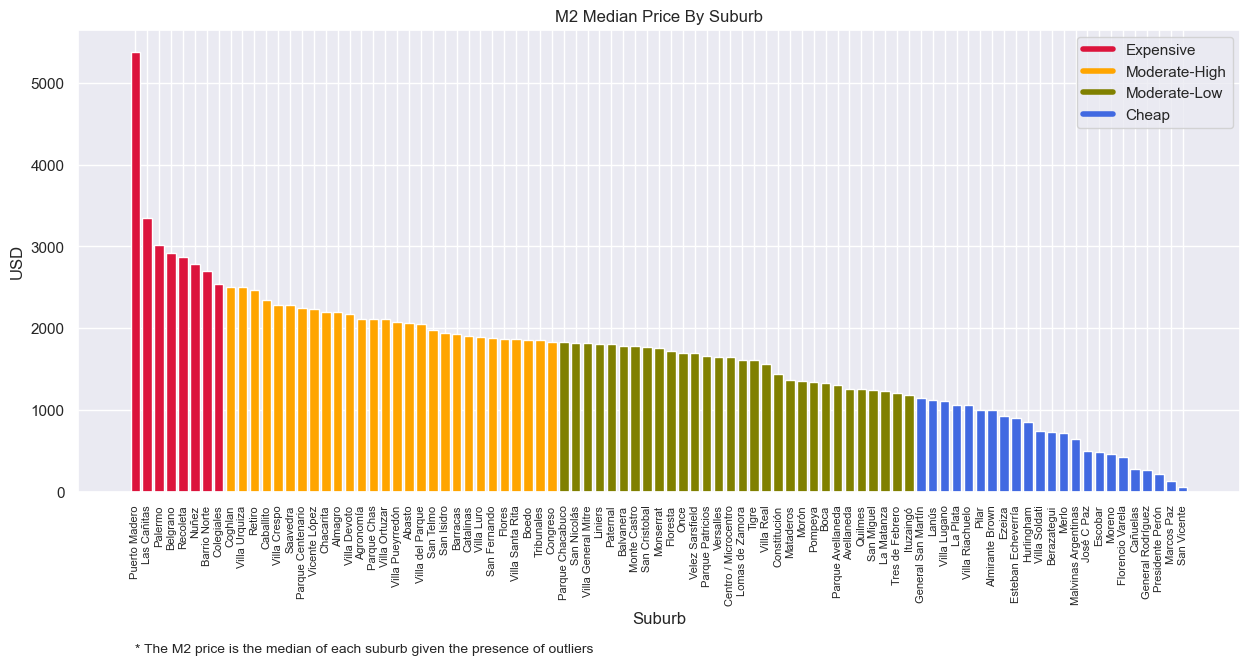

In [543]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Add "m2_price" column to de dataframe by div price / surface_total
data['m2_price'] = data['price'].div(data['surface_total'])

# Calculate the median of the price per square meter by suburb
m2_price_median_by_suburb = data.groupby('suburb_l3')['m2_price'].median().sort_values(ascending = False)
# Color 
suburb_category = pd.cut(m2_price_median_by_suburb, 
                         bins = [-np.inf, *(np.quantile(m2_price_median_by_suburb, 
                                                        [0, 0.25, 0.6, 0.9, 1])[1:-1]), np.inf],
                         labels = ['Cheap', 'Moderate-Low', 'Moderate-High', 'Expensive'])

category_colors = dict(zip(suburb_category.unique(), ['Crimson', 'Orange', 'Olive', 'Royalblue']))
# Delete m2_price from the de DataFrame
data.drop(['m2_price'], 
          axis = 1, 
          inplace = True)
# Set Seaborn style 
sns.set()
# Plot the m2 mean price per suburb
plt.figure(figsize = (15,6))

plt.bar(m2_price_median_by_suburb.index,
        height = m2_price_median_by_suburb.values,
        color  = suburb_category.map(category_colors),
        label  = category_colors)

plt.title('M2 Median Price By Suburb')
plt.ylabel('USD')
plt.xlabel('Suburb')
legend_labels = [plt.Line2D([0], [0], color = color, lw = 4, label=label)
                 for label, color in list(category_colors.items())]
plt.legend(handles = legend_labels) 
plt.text(0, -2000, '* The M2 price is the median of each suburb given the presence of outliers',
         fontsize = 10,
         ha = 'left',
         va = 'bottom')
plt.xticks(rotation = 'vertical',
           fontsize = 8)
plt.show()

The above graph presents a visualization of the price per square meter in USD for different neighborhoods. To make the graph more informative, the neighborhoods have been categorized into four distinct regions, each represented by a specific color:

- **Expensive Region:** This region is represented in red on the graph. It includes neighborhoods with significantly higher prices per square meter compared to other areas.

- **Moderate-High Region:** In the graph, this region is shown in orange. It comprises neighborhoods that have relatively high prices per square meter but not as high as those in the expensive region.

- **Moderate-Low Region:** Neighborhoods in this region are identified with the color green. They have moderate prices per square meter compared to other areas.

- **Cheap Region:** Economical neighborhoods are highlighted in blue on the graph. These neighborhoods have lower prices per square meter compared to other regions.

### Property_type

The "property_type" column represents the type of property associated with each sample. This column contains various values that describe the different types of properties listed in the dataset, such as "house," "apartment," "PH" (Penthouse), "store," "lot," and possibly others. To gain insights from this feature, we'll first explore the unique values it contains to understand the different property types present, but will focus only on the property types that are most relevant to our analysis.

Finally, we'll create visualizations to examine the distribution of prices for each of these relevant property types. This will allow us to observe any variations in property prices among different property types, which can be valuable information for our analysis.

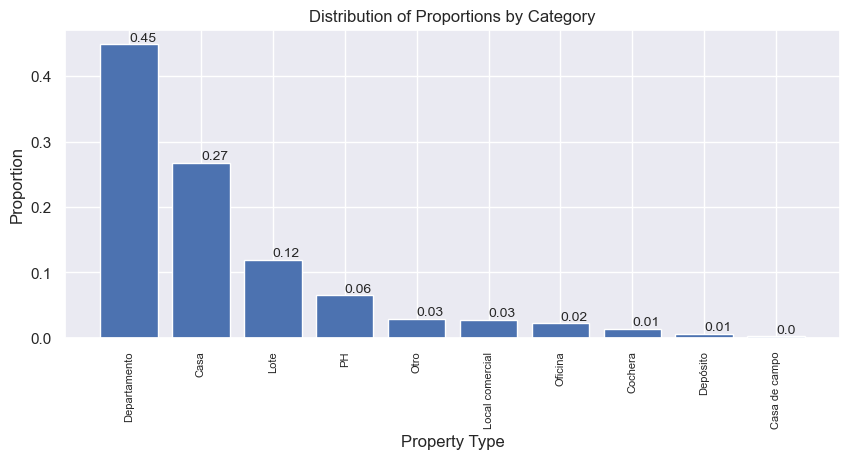

In [544]:
#Unique values of 'suburb_l3' column and their proportions in the dataframe
property_type_prop = data.groupby('property_type').size().\
                     sort_values(ascending = False) / len(data['property_type'].dropna())
# Set Seaborn style 
sns.set()
# Bar plot
plt.figure(figsize = (10, 4)) 

plt.bar(x = property_type_prop.index,
        height = property_type_prop.values)
# Labeling
plt.title('Distribution of Proportions by Category')
plt.xlabel("Property Type")
plt.ylabel("Proportion")
plt.xticks(rotation = 'vertical', fontsize = 8 )

# Annotations of proportions for each bar
for x, y in property_type_prop.items():
    plt.annotate(text = round(y, 2),
                 xy = (x, y + 0.005),
                 fontsize = 10)
plt.show()

Will be only considered categories within the 'property_type' column that have a frequency exceeding **15%**. This means that property types that appear less frequently will be excluded from our analysis. In this case, the categories 'Appartment' and 'House' meet this threshold. Therefore, these two categories will be retained in the DataFrame.

In [545]:
# Set the threshold
thresh = 0.15
# Property_type categories that meet the threshold
relevant_property_type = property_type_prop[lambda x: x > thresh].index
# Filteing the data keeping only 'house' and 'appartment' categories
data = data[data['property_type'].isin(relevant_property_type)]

## Numeric Columns

### Outliers Detection and Treatment

Finding outliers is an essential step in data analysis and modeling. Outliers can distort statistical analyses, affect model performance, and lead to misleading insights. In this context, let's to find outliers for each numeric column in the dataframe by Boxplots

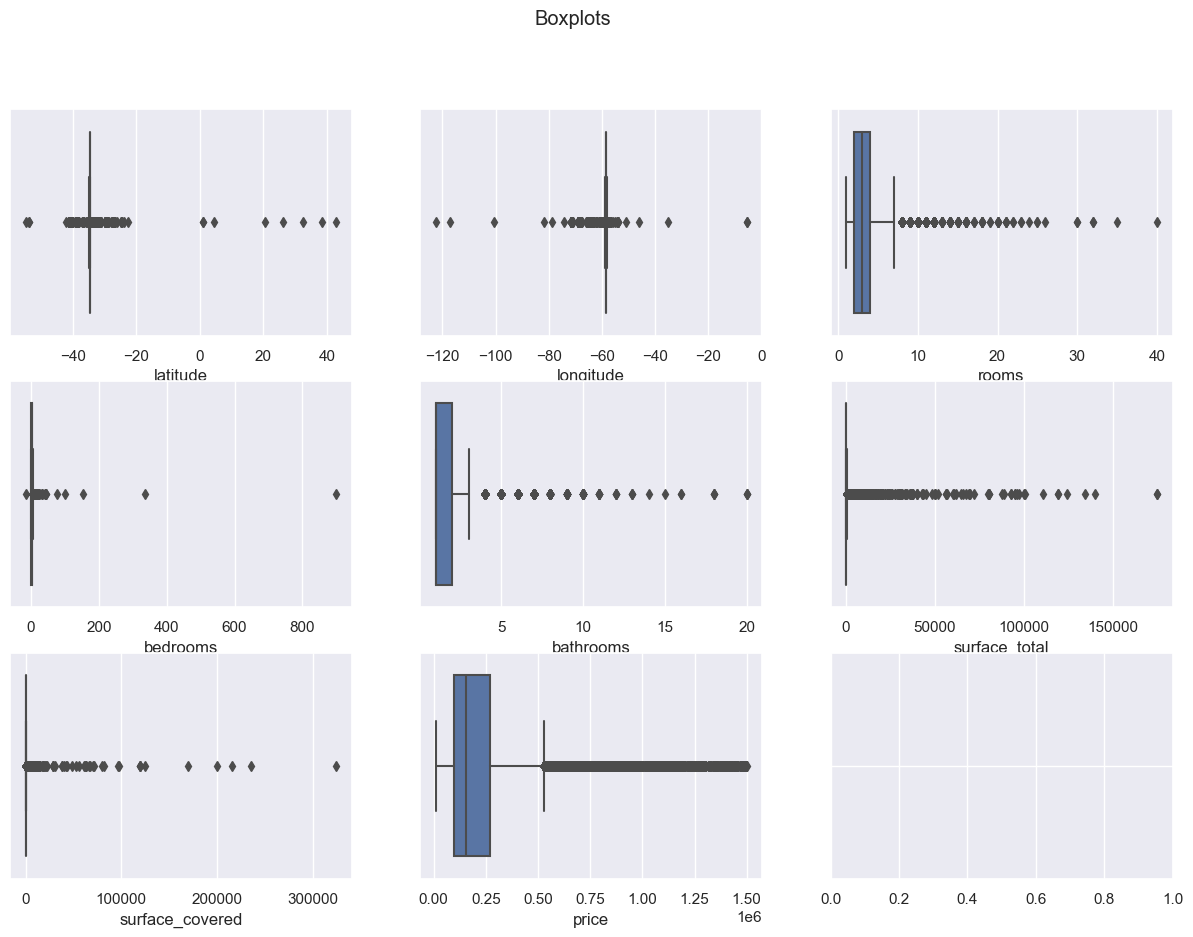

In [546]:
fig, axes = plt.subplots(3, 3, 
                         figsize = (15, 10), 
                         sharey = True)
fig.suptitle('Boxplots')
numeric_columns = data.select_dtypes(np.number).columns
# Itera sobre los ejes y las columnas numéricas
for i, ax in enumerate(axes.flatten()):
    if i < len(numeric_columns):
        sns.boxplot(x    = numeric_columns[i],
                    data = data,
                    ax   = ax)
        ax.set_xlabel(numeric_columns[i])

# Muestra los subgráficos
plt.show()


Once identified the outliers in the dataset, the next step is to determine how to handle them effectively. In this case, they will be replaced with values within the lower and upper bounds of the IQR. This method ensures that we mitigate the influence of outliers on our analyses while preserving the overall distribution of the data. The 'outlier_imputer' replaces outliers for the lower and upper bounds, as apporpriate.

In [547]:
import numpy as np

def outlier_imputer(df: pd.DataFrame, k: float = 3) -> pd.DataFrame:
    """Impute Outliers With The Lower Bounds And The Upper Bounds For Each Numeric Column"""
    assert not df.empty, "df must not be empty"
    
    # Select Numeric and Object Columns 
    df_num, df_obj = df.drop('price', axis = 1).select_dtypes('number'), df.select_dtypes('object')
    # Calculate Q1 and Q3 for each column
    Q1, Q3 = df_num.quantile(0.25).values.reshape(1, -1), df_num.quantile(0.75).values.reshape(1, -1)
    # Calculate IQR
    IQR = Q3 - Q1
    # Calculate the Lower and Upper bound for each column
    lower_bound, upper_bound = Q1 - k * IQR, Q3 + k * IQR
    # Select the columns that do allow negative values
    negative_columns = ['latitude', 'longitude']
    # Index for no-negative-columns
    negative_columns_idx = [df_num.columns.get_loc(col) for col in negative_columns]
    # Lower bounds for no-negative-columns > 0
    for i, x in enumerate(lower_bound.reshape(-1)):
        lower_bound[0,[i]] = max(x, 0) if i not in negative_columns_idx else x
    # Impute lower and upper bound for any value outside bounds
    imputed_values = np.where(df_num < lower_bound,
                              lower_bound, 
                              np.where(df_num > upper_bound,
                                       upper_bound,
                                       df_num))
    # Convert imputed_values to DataFrame keeping original indexes and columns
    df_num_imputed = pd.DataFrame(imputed_values, 
                                  index = df_num.index,
                                 columns = df_num.columns)
    # Return imputed dataframe 
    return df_num_imputed.join([df_obj, df['price']])

data = outlier_imputer(data, k = 4)


### Null Values

Now it's time to find and treat null values.

In [548]:
# Number of null values for each column
null_values = data.isna().sum()

print('Null Values quantity per columns:')
for i, (col, val) in enumerate(dict(zip(null_values.index, null_values)).items()):
    if val > 0:
        print(f"{i + 1}) {col}: {val}")

Null Values quantity per columns:
1) latitude: 26860
2) longitude: 26926
3) rooms: 28420
4) bedrooms: 43036
5) bathrooms: 15222
6) surface_total: 116780
7) surface_covered: 106135
9) suburb_l3: 1877
10) description: 2


### Data Imputer
<br>
The data_imputer function is designed to address missing values (NA) by leveraging the power of groupby operations on another column within the dataset. Specifically, it employs the median function to impute these missing values. The function constains the dictionary 'columns_dict' that contains each feature to be imputed ('imputed_col') as the keys and the columns to be groupped ('imputer_col') as the values. There are two types of imputers: When 'imputed_col' is either 'suburb_l2' or 'suburb_l3' the imputer calculates the nearest distance between the  coordinates of a given sample and the mean coordinates associated with the suburbs. The nearest suburb is the value to be imputed.
If the 'imputed_col' is other column then the imputer follows a different strategy: For example, if a sample has 3 rooms and contains missing values in the 'bedrooms' column, the imputer calculates the average number of bedrooms for properties with 3 rooms and imputes this calculated value.

In [549]:
def data_imputer(df: pd.DataFrame) -> pd.DataFrame:
    """ Function to Impute Null Values. Return the same DataFrame
        without Null Values"""
    
    assert not df.empty, "Dataframe must not be empty"
    # The Keys are the columns to impute NA Values and Values the columns used to impute
    columns_dict = {'suburb_l3':       ['latitude','longitude'],
                    'suburb_l2':       ['latitude', 'longitude'],
                    'rooms':           ['surface_total', 'surface_covered', 'bedrooms'],
                    'bedrooms':        ['rooms', 'bathrooms', 'bathrooms'],
                    'bathrooms':       ['rooms', 'bedrooms', 'surface_total', 'surface_covered'],
                    'surface_total':   ['rooms','bedrooms', 'bedrooms', 'surface_total', 'surface_covered', 'bathrooms'],
                    'surface_covered': ['rooms','bedrooms', 'bedrooms', 'surface_total', 'surface_covered', 'bathrooms'],
                    'latitude':        ['suburb_l3','suburb_l2'],
                    'longitude':       ['suburb_l3','suburb_l2']}    
    # 'group' is a Dict that contains the values to impute the NA Values for each column
    # The key is the column name to impute and the Values are the values to be imputed
    # given a criteria
    group = {}
    for key in columns_dict:
        if df[key].dtype == object:  
            group.update({key: {value: df.groupby(key)[value].median() for value in columns_dict[key]}})
        else:
            group.update({key: {value: df.groupby(value)[key].median() for value in columns_dict[key]}})
        
        def imputer_1(df: pd.DataFrame, group: pd.Series, imputed_col: str, imputer_col: str) -> np.array:
            """ Return the values to impute for the 'imputed_col' based on
                the mean values grouped by the 'imputer_col' """
            # Index to be imputed
            na_index = df[imputed_col].isna()[lambda x: x == True].index
            # Obtaining the group with values to impute NA values
            group = group.get(imputer_col)
            imputer_col_values = df.loc[na_index, imputer_col]
            return imputer_col_values.map(group)    

        def imputer_2(df: pd.DataFrame, group: pd.Series, imputed_col: str, imputer_col: str) -> str:
            """ Return the values to impute for the 'imputed_col' based on
                the minimum distance between the coordinates of the sample
                with the mean coordinates of each category of the 'imputed_col' """
            
            # Index to be imputed
            na_index = df[imputed_col].isna()[lambda x: x == True].index
            # Calculate the distance between the latitude of each sample and the latitude of the grouped column
            lat = np.abs((df.loc[na_index, 'latitude'].values.reshape(-1, 1) - group.get('latitude').values))
            # Calculate the distance between the longitude of each sample and the longitude of the grouped column
            long = np.abs((df.loc[na_index, 'longitude'].values.reshape(-1, 1) - group.get('longitude').values))
            # Select the index of the value to ve imputed
            idx = np.apply_along_axis(lambda x: np.nan if any(pd.isna(x)) else np.argmin(x),
                                      axis = 1,
                                      arr  = lat + long)
            # Values includes the unique values for the imputed_col 
            values = group.get('latitude').index
            # Select the value given the idx if is not NaN 
            return [values[int(i)] if not np.isnan(i) else np.nan for i in idx]
            
                    
    # Columns with na values
    imputed_cols = df.isna().sum().sort_values()[lambda x: (x != 0) & 
                                                 (x.index != 'description')].index
    # Delete samples with NaN Values in all columns
    mask = df[imputed_cols].isna().sum(axis = 1) < 4
    # Filter df by mask
    df = df[mask]
    
    while df.drop('description', axis = 1).isna().sum().sum() > 0:
        for imputed_col in imputed_cols:
            # Selection of the values to be imputed
            imputer_cols = columns_dict.get(imputed_col)
            # Selection the imputer given the data type of the 'imputed_col'
            if df[imputed_col].dtype == object:
                imputer = imputer_2
            else:
                imputer = imputer_1 
            
            for imputer_col in imputer_cols:
                if any(df[imputed_col].isna()):
                    # Index of NA values to be imputed
                    na_index = df[imputed_col][lambda x: pd.isna(x) == True].index
                    # Imputed values
                    imputed_values = imputer(df, group.get(imputed_col), imputed_col, imputer_col)
                    # Replace NA values
                    df.loc[na_index, imputed_col] = imputed_values
                    
    return df.drop_duplicates()

data = data_imputer(data)


The next code adjusts the 'rooms' column based on the 'bedrooms' column, so that if the number of bedrooms is greater than the number of rooms, the number of rooms is increased by 1.

In [550]:
# Define a mask
condition = data['bedrooms'] > data['rooms']
# If the number of bedrooms is higher than the number of rooms, this one will be replaced 
# for the number of bedrooms + 1
data['rooms'] = np.where(condition,
                         data['bedrooms'] + 1,
                         data['rooms'])

Similar than before, if the surface_covered is higher than the surface_total, this last one is replace for the surface_covered.

In [551]:
# Define a mask
condition = data['surface_covered'] > data['surface_total']
# # If the surface_covered is higher than the surface_total, this one will be replaced 
# for the surface_covered
data['surface_total'] = np.where(condition,
                                 data['surface_covered'],
                                 data['surface_total'])

Let's to define the function 'outliers_finder' to find outliers given a conditions. In this case, it will be applied to the 'price' column to identify values starting as a secuence '1234...'

<br>
Those samples will be removed from the dataframe

In [552]:
def outliers_finder(col: pd.Series) -> np.array(bool):
    """ Return a Boolean Array where an the element 'i' is True if
        is an string secuence as '1234...' """
    mask = [i == ''.join(np.array(np.arange(1, len(str(i)) + 1), str)) for i in map(str, col.astype(np.int64))]
    return np.array(mask)

# Mask contains True values if the 'i' price is a sequence '1234..' 
mask = outliers_finder(data['price'])
# Delete NA prices
data = data[~mask]

In [553]:
# Set the type of the columns as Integer
for col in ['rooms', 'bedrooms', 'bathrooms']:
    data[col] = data[col].astype(int)

### Data Visualization
<br>
"To find relationships between the features, Seaborn provides the Pairplot function, which allows to compare each numeric feature with itself and with the others. Each point on the plots is color based on its suburb category. There are 4 possible categories:
    - Cheap
    - Moderate - low
    - Moderate - High
    - Expensive
The category is based on the mean m2_price of the suburb.

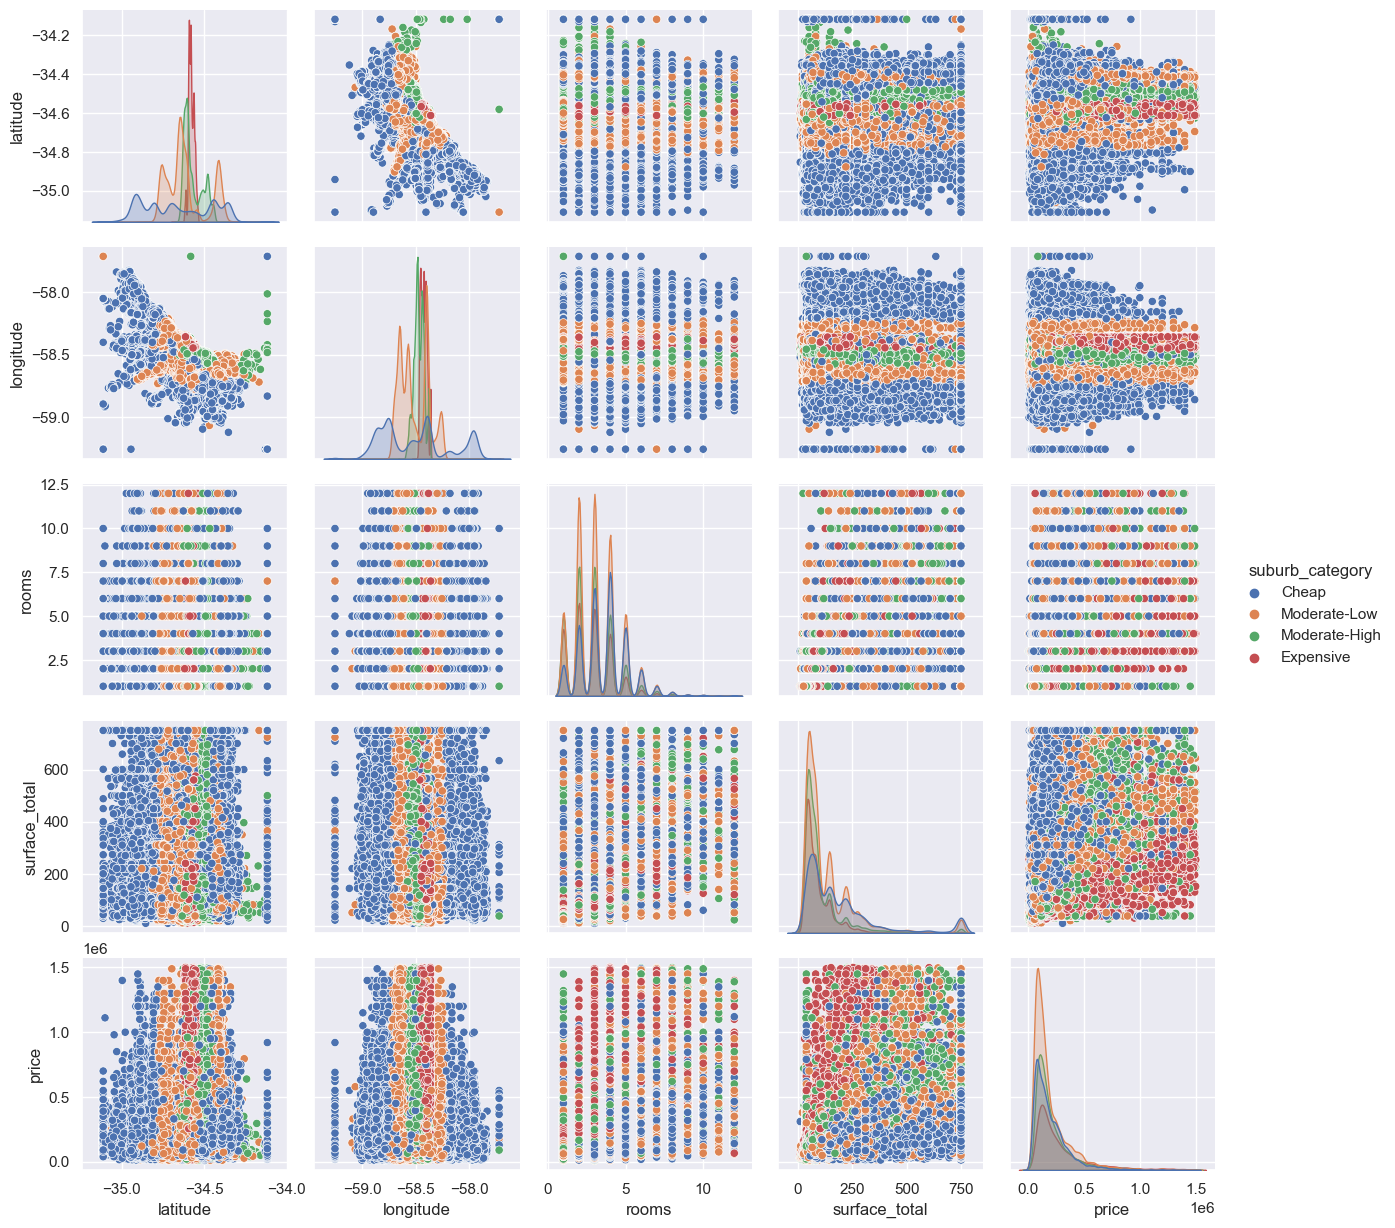

In [554]:
data['suburb_category'] = data['suburb_l3'].map(suburb_category)

sns.pairplot(data[['latitude', 'longitude', 'rooms',
                   'surface_total', 'price','suburb_category']],
             hue = 'suburb_category')
plt.show()

data.drop('suburb_category', 
          axis = 1, 
          inplace = True)

The distribution of the 'longitude' vafeature reveals that the most expensive houses are located in the city center, and as one moves towards the peripheral areas, prices decrease. When compared to longitude, it provides a visual representation of Buenos Aires, where it's evident that the center is the most expensive zone. Moving toward the north, it observes more expensive neighborhoods compared to the southern and western regions. The 'rooms' feature does not seem to exhibit a clear trend when compared to other features. Regarding the 'surface_total' feature, it becomes apparent that the most expensive properties, in terms of price per square meter, cluster at lower surface values. As surface area increases, the price per square meter decreases. The 'price' column displays a right-skewed distribution, similar to that of a log-normal function.

### Correlations

Below it generates a correlation plot for a visual representation of the relationships between the numerical variables in the dataset:

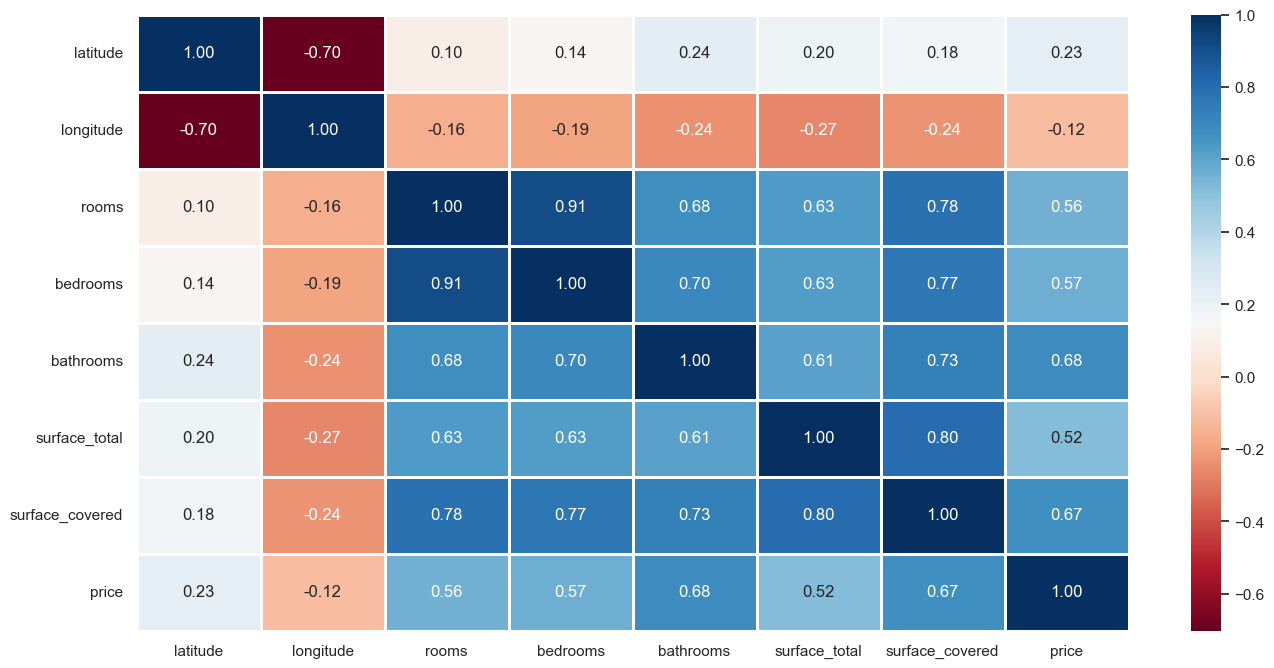

In [555]:
plt.figure(figsize = (16, 8))
sns.heatmap(data.select_dtypes(np.number).corr(),
            cmap = 'RdBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)
plt.show()

## Feature Engineering


The below code creates 12 intervals of covered_total, and is assigned as a new column into the dataframe

In [556]:
# Create 12 bins of surface_covered and it's added as a new column
n = 12
data['surface_bins'] = pd.cut(data['surface_total'],
                              bins = n,
                             labels = [f'surface_bins_{c}' for c in range(n)]
                             ).astype(object)

### Column Additions: Mapping Mean Price for Each Categorical Column

<br>
For each categorical column in the dataset, the mean price will be calculated and mapped as a new column. The 'group_mean' table contains the values for each categorical column segregated by the number of rooms, bedrooms, and bathrooms.

In [557]:
# Select only object or categorical columns
for col in data.drop('description', 
                     axis = 1).select_dtypes(object).columns:
    # Int columns are 'rooms', 'bedrooms' and 'bathrooms'
    int_cols = data.select_dtypes(int).columns.to_list()
    # New column name
    new_col_name = f"{col}_price"
    # Calculate mean m2 price grouped by the categorical columns
    group_mean = data.groupby(int_cols + [col]).mean(numeric_only = True)
    # Calculate the price per m2 for each categorical columns
    group_mean[new_col_name] = (group_mean['price']).round()
    # Add new column by mapping the multiindex of the group_mean 
    data = data.merge(group_mean[new_col_name],
                      left_on = int_cols + [col], 
                      right_index = True)

The next code calculates the ratio of "rooms" to "bathrooms" for each sample in the dataset. The calculated ratio is then assigned to a new column named "rooms_per_bathrooms". This column provides insights into the relationship between the number of rooms and bathrooms in each property.

Then, the new column 'rooms_m2_average' is the mean m2-surface of each room for each sample.

In [558]:
# Add new column called rooms_per_bathrooms 
data['rooms_per_bathrooms'] = data.apply(lambda x: round(x['rooms'] / x['bathrooms'], 2),
                                         axis = 1)

# Add new column called rooms_m2_average
data['rooms_m2_average'] = data.apply(lambda x: round(x['surface_covered'] / x['rooms'], 2), 
                                      axis = 1)

### Description column
<br>
As mentioned before, this column contains descriptive and relevant information about the properties in the add. It's a large stirng that can be used to create new columns in the dataset.
In the next code I'm going to clean the 'description' column in order to get it ready to obtain new columns by creating ngrams of size 1 and 2, and then those ones with a correlation higher than 25% with the 'price' columns will be added to the dataframe. To do that, the nlp() function is created and the applied to the dataframe.

In [559]:
import unidecode
import re

# Delete samples with NA values in the 'description' column
data = data[~pd.isna(data['description'])]
# Pass the text to lower
data['description'] = data['description'].str.lower()  
# Remove any diacritics or accents from the text
data['description'] = data['description'].apply(lambda x: unidecode.unidecode(x) 
                                                if not pd.isna(x) else None) 
# Replace HTML structures for ' '
data['description'] = data['description'].apply(lambda text: re.sub(r'<[^>]+>', ' ', text).replace('\n', ' ').strip())
# Define 'nlp' function to extract representative words to include it as feature
def nlp(column: pd.Series) -> pd.DataFrame():
    """ Generate a Boolean DataFrame That Indicates the N-grams Highly Correlated 
        With the 'price' Column """

    import stop_words
    from sklearn.feature_extraction.text import CountVectorizer
    # Getting the stop words
    stop_word = stop_words.get_stop_words('es')
    # Initialize the CountVectorizer
    vec = CountVectorizer(ngram_range = (1, 2),
                          min_df      =  int(len(column) * 0.005),
                          stop_words  =  stop_word)
    # Getting the count of words in text for each sample
    word_to_vec = pd.DataFrame(vec.fit_transform(column).todense(),
                               columns = vec.get_feature_names_out(),
                               index   = column.index)
    # Join 'price' column to de 'word_to_vec' dataframe
    df_corr = word_to_vec.join(data['price'])
    # Getting the correlation coefficient between each vector of words with the 'price' column
    correlation_matrix = np.corrcoef(df_corr, rowvar = False)
    # Create a DataFrame with the Correlation Coefficient for the 'price' column
    correlation_df = pd.DataFrame({'Correlation with price': np.abs(correlation_matrix[-1, : -1])},
                                 index = df_corr.columns[: -1])
    # Return a Dataframe cointaing the word vectors with, at least, 25% of correlation with
    # the 'price' column 
    return df_corr[list(correlation_df[lambda x: x['Correlation with price'] >= 0.25].index)] > 0

#Apply the function to 'description' column
word_to_vec = nlp(data['description'])

# Description column is no longer needed
data.drop('description',
          axis = 1, 
          inplace = True)

In [560]:
print(f"The column 'description' is split into {len(word_to_vec.columns)} new columns:\n")

for i, col in enumerate(word_to_vec.columns):
    print(f"{i + 1}) {col}") 

The column 'description' is split into 25 new columns:

1) comedor
2) comedor diario
3) dependencia
4) dependencia servicio
5) diario
6) doble
7) dormitorios
8) dormitorios suite
9) escritorio
10) family
11) galeria
12) jardin
13) lavadero
14) master
15) master suite
16) playroom
17) principal
18) recepcion
19) riego
20) servicio
21) servicio bano
22) suite
23) suite vestidor
24) toilette
25) vestidor


## Column Selection

The above code identifies columns that have a correlation greater than 85% with any other column and removes them from consideration. This helps to reduce multicollinearity in the dataset by selecting only those features that are relatively independent of each other.

In [561]:
# Column to predict
y_col = 'price'
# Correlation matrix
correlation_matrix = data.drop([y_col, 'price'], axis = 1).select_dtypes(np.number).corr()

for col in correlation_matrix.columns:
    if col in correlation_matrix.columns:
        # Mask to get filter the lower triangle of the correlation matrix
        mask = np.tri(correlation_matrix.shape[0], 
                      k = 1, 
                      dtype = bool)
        # Get the name of columns with correlation above 85%
        correlated_col = correlation_matrix.where(mask).stack()[col].abs().between(0.85, 0.999)
        correlated_col = correlated_col[lambda x: x == True].index
        # Drop the correlated column from the matrix
        correlation_matrix.drop(index   = correlated_col,
                                columns = correlated_col,
                                inplace = True)

print("Selected Columns:")
for col in correlation_matrix.columns:
    print(f"- {col}")

Selected Columns:
- latitude
- longitude
- rooms
- surface_total
- surface_covered
- property_type_price
- rooms_per_bathrooms
- rooms_m2_average


## Dummies

<br>
The categorical columns will be represented as dummy columns

In [562]:
dummy_col = data.select_dtypes(object).columns
dummies = pd.get_dummies(data[dummy_col])

## Merging data

The final dataframe combine the set of columns of the correlation_matrix, the dummies, the words to vector columns and the 'price' column 

In [563]:
data = pd.concat([data[correlation_matrix.columns],
                  dummies, 
                  word_to_vec, 
                  data[y_col]], 
                 axis = 1)                       

## Data Sceling and split
<br>
The regressors will be represented as 'X' and the predicted as 'y'. Then the regressors 'X' are scaled and finally, the data is splitted in training and testing.

In [565]:
from sklearn.preprocessing import MinMaxScaler
# Regressors
X = data.drop(y_col, 
              axis = 1).copy()
# Predicted
y = data[y_col].copy()

# Intitialize the scaled
scaler = MinMaxScaler()
# Convert the scaled matrix as DataFrame keeping same indexes and columns
X_transformed = pd.DataFrame(scaler.fit_transform(X), 
                        index = X.index,
                        columns = X.columns)

from sklearn.model_selection import train_test_split
# Data splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_transformed,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

### Quality Measure  Functions

Next function will be used to compare the quality of the models between different combination of parameters and between each model. 
- rmse(): Provides the RMSE bewtween the predicted col and the predictions
- rmse_norm(): Provides a RMSE normalized by divide it for the price average
- min_max_scaler():
- model_eval(): Provides the graphic to compare the rmse for all combination of parameters between the training and the testing dataframes. Also returns the results of the cross-validation.

In [1]:
from sklearn.metrics import mean_squared_error

def rmse(pred: np.ndarray, y: pd.Series) -> int:
    """ Return the RMSE of the model """
    return int(np.sqrt(mean_squared_error(pred, y)))

def rmse_norm(rmse: int) -> float:
    """ Return the normilized RMSE """
    return float((rmse / data[y_col].mean()).round(2))

def model_eval(model_name: str, results: dict) -> (pd.DataFrame, plt.figure) :
    """ Returns two objects: The first one is a DataFrame with the results of the CV,
        and the second one it's a graphic of the Bias-Variance Trade Off """
    
    results = pd.DataFrame({'params': results['params'],
                            'mean_test_score': np.sqrt(-results['mean_test_score']),
                            'mean_train_score': np.sqrt(-results['mean_train_score'])
                           }).sort_values('mean_train_score', 
                                          ascending = False)
    # Seaborn style 
    sns.set()
    # Plot the Test Bias
    plt.plot(np.arange(len(results.index)),
             results['mean_test_score'].values,
             label = 'Bias Test',
             marker = 'x')

    # Plot the Train Bias
    plt.plot(np.arange(len(results.index)),
             results['mean_train_score'].values,
             label = 'Bias Train',
             marker = 'x')
    #Labels
    plt.title(f'{model_name} Model: Bias - Variance Trade-Off')
    plt.xlabel('Hyperparameter index')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    
    return results, plt

NameError: name 'np' is not defined

## Models

The models to be used for predicting property prices are K-Nearest Neighbors (KNN), Random Forest, and XGBoost. For each of these models, a parameter grid will be utilized, and the quality of the model will be assessed using the model_eval() function. The goal is to identify the optimal parameter combinations for each model that strike a balance between bias and variance, ultimately leading to improved predictive performance.

### KNN model

In [585]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Grid of hyperparameters for KNN Model
knn_param_grid = {
    'n_neighbors': [6, 8, 9, 10, 12, 16]
}
# Initialize KNN Model
knn_model = KNeighborsRegressor()
# Grid Search with 5-fold Cross-Validation for the KNN Model
knn_grid_search = GridSearchCV(estimator = knn_model, 
                               param_grid = knn_param_grid, 
                               cv = 5 , 
                               n_jobs = -1, 
                               scoring = 'neg_mean_squared_error',
                               return_train_score = True)
# Fit the grid of hyperparameters to the training set
knn_grid_search.fit(X_train, 
                    y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [4, 6, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

### KNN model evaluation

The model_eval() function tracks RMSE changes for training and validation sets across different hyperparameters in the KNN model grid. Let's see the graphic with the evolution of the RMSE


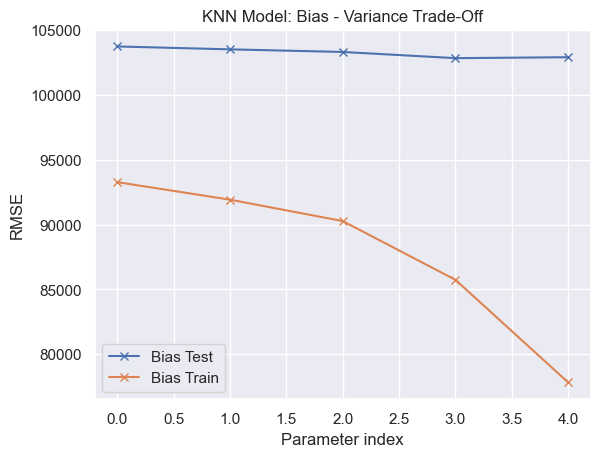

In [938]:
knn_results, knn_plt = model_eval(model_name = 'KNN',
                                  results = knn_grid_search.cv_results_)
knn_plt.show()

### Parameter Selection for K-Nearest Neighbors (KNN)

The selection of the optimal parameter for the K-Nearest Neighbors (KNN) model involves finding the value of K that provides the best balance between training and testing performance. To make this selection, we examine a graph that compares the RMSE for the training set and the test set across different values of K. It can observe that the RMSE values for the training and test sets start to diverge from the K parameter located in the index number 2. Beyond this point, the model tends to overfit the training data.

Below, the selected K parameter is used to tune the model. The RMSE for the test set and the normalized RMSE, allowing us to make meaningful comparisons with other models.


In [939]:
# KNN Best Model
knn_best_model = KNeighborsRegressor(**knn_results['params'][2])
# KNN model tuning
knn_best_model.fit(X_train, y_train)
# Test RMSE for KNN Model
knn_rmse = rmse(knn_best_model.predict(X_test), y_test)
# Test RMSE normalized for KNN Model
knn_rmse_norm = rmse_norm(knn_rmse)

print(f"Best K: {knn_results['params'][2].get('n_neighbors')}")
print('-----'*8)
print(f'Final RMSE for KNN Model: {knn_rmse}\nFinal RMSE normalized for KNN Model: {knn_rmse_norm}')

Best K: 8
----------------------------------------
Final RMSE for KNN Model: 101017
Final RMSE normalized for KNN Model: 0.45


## Random Forest Model

In [603]:
from sklearn.ensemble import RandomForestRegressor
# Grid of hyperparameters for the Random Forest Model
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [15],
    'min_samples_split': [5, 15, 25],
    'min_samples_leaf': [4, 6],
    'max_features': ['sqrt', None]
}
# Initialize Random Forest Model
rf_model = RandomForestRegressor(random_state = 42)

# Grid Search with 5-fold Cross-Validation for the Random Forest Model
rf_grid_search = GridSearchCV(estimator = rf_model,
                              param_grid = param_grid, 
                              cv = 5, 
                              n_jobs = -1, 
                              scoring = 'neg_mean_squared_error',
                              return_train_score = True)
# Fit the grid of hyperparameters to the training set
rf_grid_search.fit(X_train, 
                   y_train)

RMSE train: 67336
RMSE test: 84149


### Ranfom Forest model evaluation

Let's see the results for the Random Forest Model


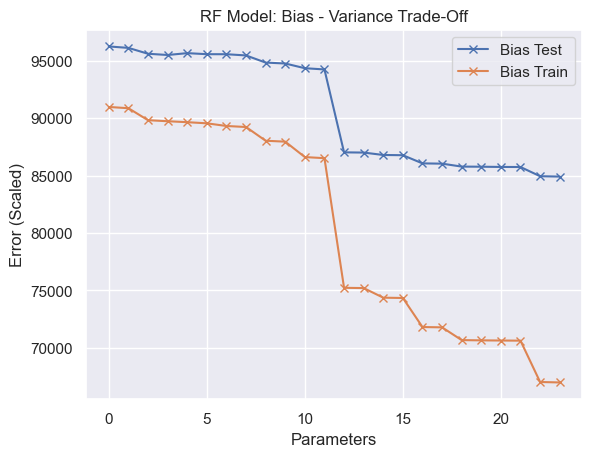

In [619]:
rf_results, rf_plt = model_eval(model_name = 'RF',
                                results = rf_grid_search.cv_results_)
rf_plt.show()

### Parameter Selection for Random Forest
In the Random Forest model, the search for the best hyperparameter combination is located at index 15. This combination shows an optimal balance between training and testing performance. Beyond this index, the model's performance on the test set begins to degrade.

Subsequently, we fine-tune the model using the selected hyperparameters. The RMSE is calculated for the test set and it's normalized RMSE.

In [940]:
# Random Forest Best Model
rf_best_model = RandomForestRegressor(random_state = 42,
                                      **rf_results['params'][15])
# Random Forest Model tuning
rf_best_model.fit(X_train,
                  y_train)
# Test RMSE for Random Forest Model
rf_rmse = rmse(rf_best_model.predict(X_test),
                y_test)
# Test RMSE normalized for Random Forest Model
rf_rmse_norm = rmse_norm(rf_rmse)

print(f"Best Hyperparameters:")
for param_name, param in rf_results['params'][15].items():
    print(f"{param_name: <20}: {param}")

print('-----'*8)
print(f'Final RMSE for RF Model: {rf_rmse}\nFinal RMSE normalized for RF Model: {rf_rmse_norm}')

Best Hyperparameters:
max_depth           : 15
max_features        : None
min_samples_leaf    : 4
min_samples_split   : 15
n_estimators        : 1000
----------------------------------------
Final RMSE for RF Model: 84984
Final RMSE normalized for RF Model: 0.38


### XGBoost

In [605]:
import xgboost as xgb
# Grid of hyperparameters for XGB Model
xgb_model = xgb.XGBRegressor(random_state = 42)
# Initialize KNN Model
param_grid = {
    'n_estimators': [1000, 1500],
    'learning_rate': [0.01, 0.02],
    'max_depth': [7, 15, 25],  
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8],  
    'colsample_bytree': [0.8], 
    'gamma': [0.1] 
}
# Grid Search with 5-fold Cross-Validation for the XGB Model
xgb_grid_search = GridSearchCV(xgb_model, 
                               param_grid, 
                               cv = 5,
                               n_jobs = -1, 
                               scoring = 'neg_mean_squared_error',
                               return_train_score = True)
# Fit the grid of hyperparameters to the training set
xgb_grid_search.fit(X_train, 
                    y_train)

RMSE train: 26414
RMSE test: 71552


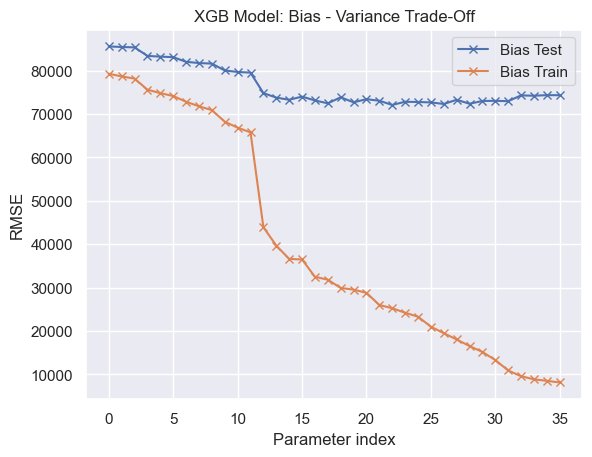

In [676]:
xgb_results, xgb_plt = model_eval(model_name = 'XGB', 
                                  results = xgb_grid_search.cv_results_)
xgb_plt.show()

best combination of parames: 

In [866]:
xgb_best_model = xgb.XGBRegressor(random_state = 42,
                                  **xgb_results['params'][11])
xgb_best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=15, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

### Hyperpameter Selection for XGBoost
In the XGBoost model, the best hyperparameter combination is found at index 11. This particular combination demonstrates an optimal equilibrium between the model's training and testing performance. When moving beyond this index, there is a noticeable degradation in the model's performance on the test set.

In [941]:
# XGB Best Model
xgb_best_model = xgb.XGBRegressor(random_state = 42,
                                  **xgb_results['params'][11])
# XGB Model tuning
xgb_best_model.fit(X_train,
                   y_train)
# Test RMSE for XGB Model
xgb_rmse = rmse(xgb_best_model.predict(X_test),
                y_test)
# Test RMSE normalized for XGB Model
xgb_rmse_norm = rmse_norm(xgb_rmse)

print(f"Best Hyperparameters:")
for param_name, param in xgb_results['params'][15].items():
    print(f"{param_name: <20}: {param}")

print('-----'*8)
print(f'Final RMSE for XGB Model: {xgb_rmse}\nFinal RMSE normalized for XGB Model: {xgb_rmse_norm}')

Best Hyperparameters:
colsample_bytree    : 0.8
gamma               : 0.1
learning_rate       : 0.01
max_depth           : 25
min_child_weight    : 5
n_estimators        : 1500
subsample           : 0.8
----------------------------------------
Final RMSE for XGB Model: 73244
Final RMSE normalized for XGB Model: 0.33


## Conclusion: Model Selection
Among the models we considered, the XGBoost (XGB) model emerges as the most promising choice. It exhibits a lower Root Mean Squared Error (RMSE) on the test set, and when examining the normalized RMSE, it diverges from the mean by only 33% compared to both the Random Forest (RF) and K-Nearest Neighbors (KNN) models.

Therefore, with the selected hyperparameters, XGBoost represents the optimal model for predicting property prices in Buenos Aires.